In [ ]:
# ---- Dataset Upload ----
from google.colab import files
uploaded = files.upload()



Saving kvasir-seg.zip to kvasir-seg.zip


In [ ]:
# ---- Extract the dataset ----
import os, zipfile
zip_path = list(uploaded.keys())[0]   # 'kvasir-seg.zip'
extract_root = "kvasir-seg"
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_root)

print("Extracted to:", extract_root)
print("Top-level:", os.listdir(extract_root))

dataset_dir = os.path.join(extract_root, "Kvasir-SEG")
images_path  = os.path.join(dataset_dir, "images")
masks_path   = os.path.join(dataset_dir, "masks")
print("Dataset dir:", dataset_dir)
print("Subfolders:", os.listdir(dataset_dir))


Extracted to: kvasir-seg
Top-level: ['Kvasir-SEG']
Dataset dir: kvasir-seg/Kvasir-SEG
Subfolders: ['kavsir_bboxes.json', 'masks', 'images']


In [ ]:
extract_path = "kvasir-seg"

Number of images: 1000
Number of masks : 1000
Example image: cju0qkwl35piu0993l0dewei2.jpg
Example mask : cju0qkwl35piu0993l0dewei2.jpg


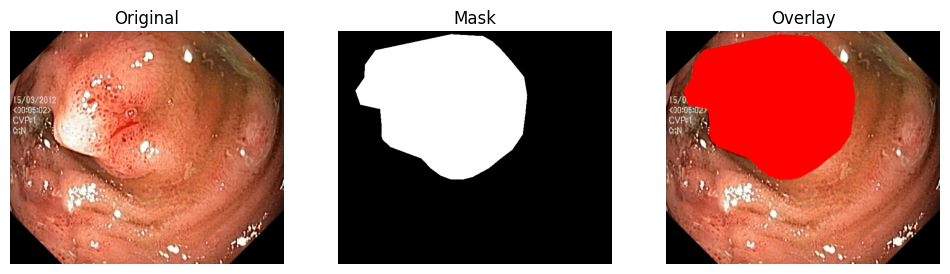

In [ ]:
# ---- Verify dataset structure ----
import os, cv2, matplotlib.pyplot as plt

dataset_path = os.path.join(extract_path, "Kvasir-SEG")
images_path  = os.path.join(dataset_path, "images")
masks_path   = os.path.join(dataset_path, "masks")

images = sorted(os.listdir(images_path))
masks  = sorted(os.listdir(masks_path))

print("Number of images:", len(images))
print("Number of masks :", len(masks))
print("Example image:", images[0])
print("Example mask :", masks[0])


img  = cv2.cvtColor(cv2.imread(os.path.join(images_path, images[0])), cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(masks_path, masks[0]), cv2.IMREAD_GRAYSCALE)

overlay = img.copy()
overlay[mask > 127] = [255, 0, 0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img);    plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.show()


Preprocess + Split Train/Val/Test split (70/15/15) and DataFrames





In [ ]:
#Preprocess + Split
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd, torch

SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)

def stem(name): return os.path.splitext(name)[0]

stems = [stem(f) for f in images]

train_stems, tmp = train_test_split(stems, test_size=0.30, random_state=SEED, shuffle=True)
val_stems,   test_stems = train_test_split(tmp, test_size=0.50, random_state=SEED, shuffle=True)

def find_with_ext(folder, s):
    for ext in (".png",".jpg",".jpeg"):
        p = os.path.join(folder, s+ext)
        if os.path.exists(p): return p
    raise FileNotFoundError(s)

def make_df(stems_list):
    return pd.DataFrame({
        "image":[find_with_ext(images_path, s) for s in stems_list],
        "mask" :[find_with_ext(masks_path,  s) for s in stems_list]
    })

train_df, val_df, test_df = make_df(train_stems), make_df(val_stems), make_df(test_stems)
print(f"Split sizes -> Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Split sizes -> Train: 700 | Val: 150 | Test: 150


**Task 6**

In [ ]:
#6.1 Dataset & DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader

IMG_SIZE = 128

class KvasirSeg(Dataset):
    def __init__(self, df): self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        import numpy as np, cv2
        im = cv2.cvtColor(cv2.imread(self.df.loc[i,"image"]), cv2.COLOR_BGR2RGB)
        mk = cv2.imread(self.df.loc[i,"mask"],  cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0
        mk = (cv2.resize(mk, (IMG_SIZE, IMG_SIZE)) > 127).astype(np.float32)
        im = torch.from_numpy(np.transpose(im, (2,0,1))).float()   # [3,H,W]
        mk = torch.from_numpy(mk).unsqueeze(0).float()             # [1,H,W]
        return im, mk

# CPU-friendly loaders
train_loader = DataLoader(KvasirSeg(train_df), batch_size=4, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(KvasirSeg(val_df),   batch_size=4, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(KvasirSeg(test_df),  batch_size=4, shuffle=False, num_workers=0, pin_memory=False)

xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)  # expect [4,3,128,128] and [4,1,128,128]


Batch shapes: torch.Size([4, 3, 128, 128]) torch.Size([4, 1, 128, 128])


In [ ]:
#6.2 U-Net
import torch, torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNetSmall(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super().__init__()
        # Encoder
        self.enc1 = DoubleConv(in_c, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        # Bottleneck
        self.bot  = DoubleConv(512, 1024)
        # Decoder
        self.up4  = nn.ConvTranspose2d(1024, 512, 2, 2); self.dec4 = DoubleConv(1024, 512)
        self.up3  = nn.ConvTranspose2d(512, 256, 2, 2);  self.dec3 = DoubleConv(512, 256)
        self.up2  = nn.ConvTranspose2d(256, 128, 2, 2);  self.dec2 = DoubleConv(256, 128)
        self.up1  = nn.ConvTranspose2d(128, 64,  2, 2);  self.dec1 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, out_c, 1)   # logits (no sigmoid here)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        xb = self.bot(self.pool(x4))
        x  = self.up4(xb); x = torch.cat([x, x4], 1); x = self.dec4(x)
        x  = self.up3(x);  x = torch.cat([x, x3], 1); x = self.dec3(x)
        x  = self.up2(x);  x = torch.cat([x, x2], 1); x = self.dec2(x)
        x  = self.up1(x);  x = torch.cat([x, x1], 1); x = self.dec1(x)
        return self.outc(x)

model = UNetSmall()
print(model)


UNetSmall(
  (enc1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (bloc

**Dataset/Dataloaders**

In [ ]:
#Task 7 Dataset/Dataloaders
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

bce_logits = nn.BCEWithLogitsLoss()

def dice_soft(logits, target, eps=1e-7):
    p = torch.sigmoid(logits); p = p.view(p.size(0),-1); t = target.view(target.size(0),-1)
    inter=(p*t).sum(1); union=p.sum(1)+t.sum(1)
    return ((2*inter+eps)/(union+eps)).mean()

def iou_soft(logits, target, eps=1e-7):
    p = torch.sigmoid(logits); p = p.view(p.size(0),-1); t = target.view(target.size(0),-1)
    inter=(p*t).sum(1); union=p.sum(1)+t.sum(1)-inter
    return ((inter+eps)/(union+eps)).mean()

def loss_fn(logits, target):
    return bce_logits(logits, target) + (1.0 - dice_soft(logits, target))

opt = Adam(model.parameters(), lr=1e-3)
sch = ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)


In [ ]:
#(7.2) Loss/metrics/optim/scheduler
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

bce_logits = nn.BCEWithLogitsLoss()

def dice_soft(logits, target, eps=1e-7):
    p = torch.sigmoid(logits); p = p.view(p.size(0),-1); t = target.view(target.size(0),-1)
    inter=(p*t).sum(1); union=p.sum(1)+t.sum(1)
    return ((2*inter+eps)/(union+eps)).mean()

def iou_soft(logits, target, eps=1e-7):
    p = torch.sigmoid(logits); p = p.view(p.size(0),-1); t = target.view(target.size(0),-1)
    inter=(p*t).sum(1); union=p.sum(1)+t.sum(1)-inter
    return ((inter+eps)/(union+eps)).mean()

def loss_fn(logits, target):
    return bce_logits(logits, target) + (1.0 - dice_soft(logits, target))

opt = Adam(model.parameters(), lr=1e-3)
sch = ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)


Epoch 01 | Train L 1.3656 D 0.276 IoU 0.169 || Val L 1.4022 D 0.191 IoU 0.110
Epoch 02 | Train L 1.1776 D 0.323 IoU 0.205 || Val L 1.4903 D 0.119 IoU 0.067
Epoch 03 | Train L 1.1716 D 0.312 IoU 0.197 || Val L 1.3155 D 0.224 IoU 0.133


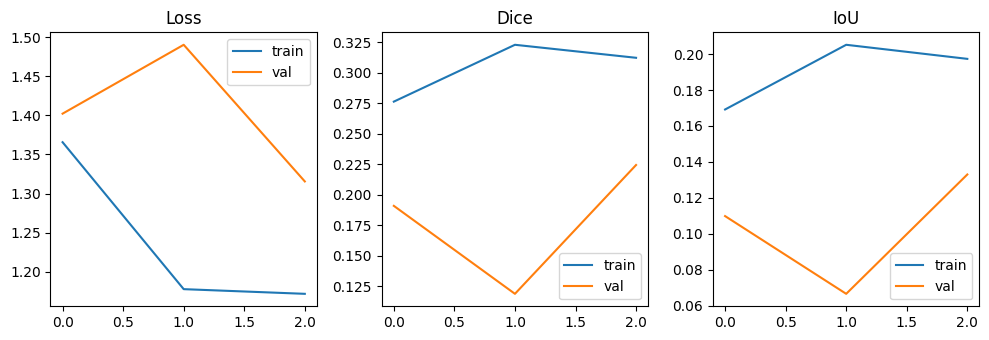

Best validation Dice: 0.224


In [ ]:
#7.3 Training loop
import matplotlib.pyplot as plt

EPOCHS = 3
MAX_TRAIN_BATCHES = 10     # cap per epoch to keep it quick
MAX_VAL_BATCHES   = 5

history = {"trL":[], "vaL":[], "trD":[], "vaD":[], "trI":[], "vaI":[]}
BEST_PATH = "unet_kvasir_best.pt"; best_val = -1.0

def run_epoch(loader, train=True, max_batches=None):
    model.train(mode=train)
    TL=TD=TI=0.0; n=0
    for b,(imgs,msks) in enumerate(loader):
        if max_batches is not None and b >= max_batches: break
        imgs,msks = imgs.to(device), msks.to(device)
        if train:
            opt.zero_grad(set_to_none=True)
            z = model(imgs); L = loss_fn(z, msks)
            L.backward(); opt.step()
        else:
            with torch.no_grad(): z = model(imgs); L = loss_fn(z, msks)
        with torch.no_grad():
            TL += float(L); TD += float(dice_soft(z, msks)); TI += float(iou_soft(z, msks)); n += 1
    return TL/n, TD/n, TI/n

for ep in range(1, EPOCHS+1):
    trL,trD,trI = run_epoch(train_loader, True,  MAX_TRAIN_BATCHES)
    vaL,vaD,vaI = run_epoch(val_loader,   False, MAX_VAL_BATCHES)
    sch.step(vaD)

    history["trL"].append(trL); history["vaL"].append(vaL)
    history["trD"].append(trD); history["vaD"].append(vaD)
    history["trI"].append(trI); history["vaI"].append(vaI)

    if vaD > best_val:
        best_val = vaD
        torch.save(model.state_dict(), BEST_PATH)

    print(f"Epoch {ep:02d} | Train L {trL:.4f} D {trD:.3f} IoU {trI:.3f} || Val L {vaL:.4f} D {vaD:.3f} IoU {vaI:.3f}")

plt.figure(figsize=(10,3.5))
plt.subplot(1,3,1); plt.plot(history["trL"],label='train'); plt.plot(history["vaL"],label='val'); plt.title('Loss'); plt.legend()
plt.subplot(1,3,2); plt.plot(history["trD"],label='train'); plt.plot(history["vaD"],label='val'); plt.title('Dice'); plt.legend()
plt.subplot(1,3,3); plt.plot(history["trI"],label='train'); plt.plot(history["vaI"],label='val'); plt.title('IoU');  plt.legend()
plt.tight_layout(); plt.show()

print(f"Best validation Dice: {best_val:.3f}")


In [ ]:
#8.1 Threshold τ on validation

import numpy as np

model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.to(device); model.eval()

@torch.no_grad()
def mean_dice_at(loader, tau=0.5, eps=1e-7):
    scores=[]
    for x,y in loader:
        p = model(x.to(device)).cpu().numpy()[:, 0]
        t = y.numpy()[:,0].astype(np.float32)
        b = (p>tau).astype(np.float32)
        tp=(b*t).sum((1,2)); fp=(b*(1-t)).sum((1,2)); fn=((1-b)*t).sum((1,2))
        scores += ((2*tp+eps)/(2*tp+fp+fn+eps)).tolist()
    return float(np.mean(scores))

taus = np.linspace(0.40, 0.60, 5)  # small sweep for CPU
val_dices = [mean_dice_at(val_loader, t) for t in taus]
best_tau = float(taus[int(np.argmax(val_dices))])
print(f"Best τ on validation = {best_tau:.2f} (Dice={max(val_dices):.3f})")


Best τ on validation = 0.40 (Dice=0.178)


In [ ]:
#8.2 Test metrics (micro + macro) and confusion matrix counts
@torch.no_grad()
def test_with_confusion(loader, tau=0.5, eps=1e-7):
    TP=FP=TN=FN=0
    diceL=[]; iouL=[]; precL=[]; recL=[]
    for x,y in loader:
        p = model(x.to(device)).cpu().numpy()[:, 0]
        t = y.numpy()[:,0].astype(np.float32)
        b = (p>tau).astype(np.float32)
        tp=(b*t).sum((1,2)); fp=(b*(1-t)).sum((1,2))
        fn=((1-b)*t).sum((1,2)); tn=((1-b)*(1-t)).sum((1,2))
        TP+=int(tp.sum()); FP+=int(fp.sum()); FN+=int(fn.sum()); TN+=int(tn.sum())
        diceL += ((2*tp+eps)/(2*tp+fp+fn+eps)).tolist()
        iouL  += ((tp+eps)/(tp+fp+fn+eps)).tolist()
        precL += ((tp+eps)/(tp+fp+eps)).tolist()
        recL  += ((tp+eps)/(tp+fn+eps)).tolist()
    micro = {"Dice":(2*TP)/(2*TP+FP+FN+eps), "IoU":(TP)/(TP+FP+FN+eps),
             "Precision":(TP)/(TP+FP+eps), "Recall":(TP)/(TP+FN+eps),
             "Confusion":np.array([[TN,FP],[FN,TP]], dtype=np.int64)}
    macro = {"Dice":float(np.mean(diceL)), "IoU":float(np.mean(iouL)),
             "Precision":float(np.mean(precL)), "Recall":float(np.mean(recL))}
    return micro, macro

micro, macro = test_with_confusion(test_loader, tau=best_tau)
print("TEST (micro):", {k:(v if k!='Confusion' else 'see matrix') for k,v in micro.items()})
print("TEST (macro):", macro)

TEST (micro): {'Dice': 0.2815175329655613, 'IoU': 0.16381751828482263, 'Precision': 0.3230336336493953, 'Recall': 0.24945740744040423, 'Confusion': 'see matrix'}
TEST (macro): {'Dice': 0.17369364024560008, 'IoU': 0.12310639772188736, 'Precision': 0.5896687417261417, 'Recall': 0.245435923156882}


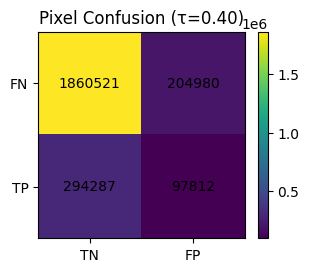

In [ ]:
# 8.3 — Confusion matrix heatmap
cm = micro["Confusion"]
import matplotlib.pyplot as plt, numpy as np
plt.figure(figsize=(3.2,3))
plt.imshow(cm, interpolation="nearest")
plt.xticks([0,1], ["TN","FP"]); plt.yticks([0,1], ["FN","TP"])
plt.title(f"Pixel Confusion (τ={best_tau:.2f})"); plt.colorbar(shrink=0.8)
for (i,j),v in np.ndenumerate(cm): plt.text(j,i,int(v),ha='center',va='center')
plt.tight_layout(); plt.show()


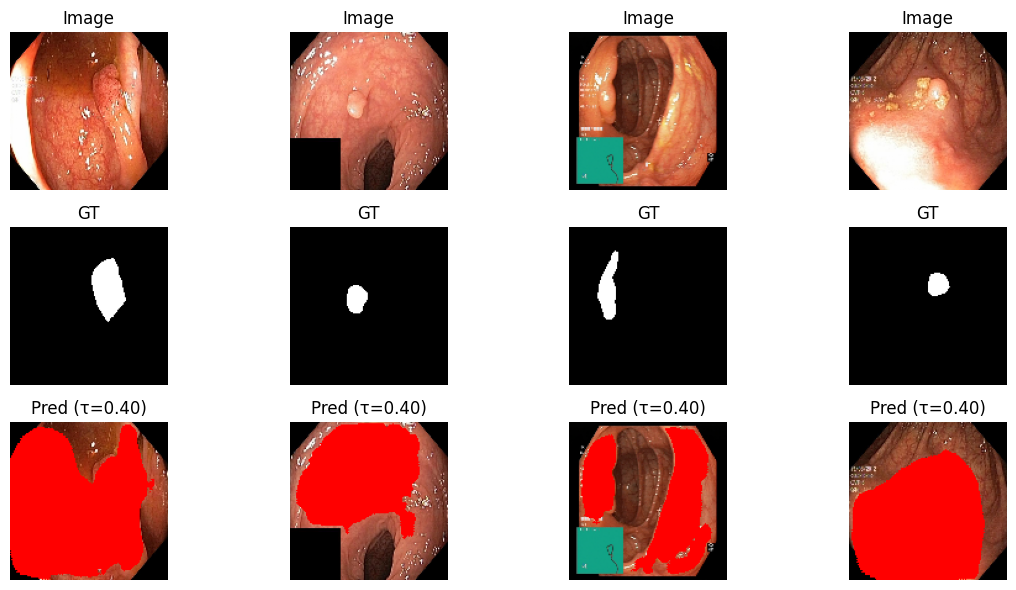

In [ ]:
# Qualitative grid
imgs_v, msks_v = next(iter(test_loader))
with torch.no_grad():
    probs_v = torch.sigmoid(model(imgs_v.to(device))).cpu().numpy()[:,0]

plt.figure(figsize=(12,6))
for i in range(min(4, imgs_v.size(0))):
    im = imgs_v[i].permute(1,2,0).numpy()
    gt = msks_v[i][0].numpy()
    bm = (probs_v[i]>best_tau).astype(np.float32)
    ov = im.copy(); ov[bm>0] = [1.0,0.0,0.0]
    plt.subplot(3,4,i+1); plt.imshow(im); plt.axis('off'); plt.title("Image")
    plt.subplot(3,4,i+5); plt.imshow(gt, cmap='gray'); plt.axis('off'); plt.title("GT")
    plt.subplot(3,4,i+9); plt.imshow(ov); plt.axis('off'); plt.title(f"Pred (τ={best_tau:.2f})")
plt.tight_layout(); plt.show()